# $\textbf{Wind power forecasting}$
### $\textit{Kirill Zakharov}$
##### $\textit{@kirillzx}$
$2021$

In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, QuantileTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from fbprophet import Prophet

In [4]:
data = pd.read_csv('Turbine_Data.csv', parse_dates=True, index_col='Unnamed: 0')
data.index = pd.DatetimeIndex(data.index, freq='10T')
data = data.drop(['WTG', 'ControlBoxTemperature'], axis=1)
data = data.tz_localize(None)
names = data.columns

In [5]:
# data = data.resample('D').last()
data.head(3)

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
2017-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


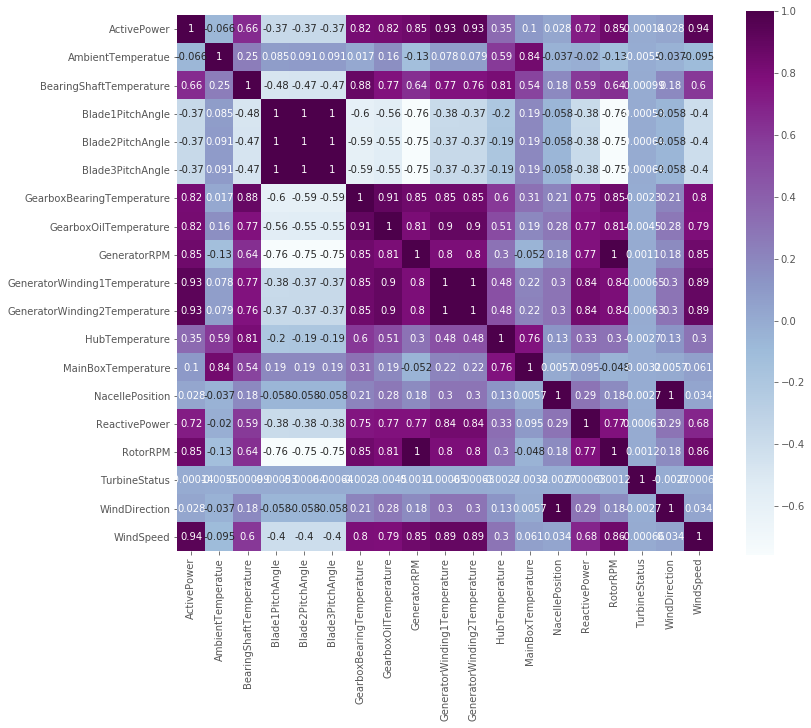

In [6]:
fig = plt.figure(figsize=(12,10))

sns.heatmap(data.corr(), annot=True, cmap='BuPu', square=True, linewidth=0)
b1,t1=plt.ylim()
b1+=0.5
t1-=0.5
plt.ylim(b1, t1)
plt.show()

In [7]:
data.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,94750.000000,93817.000000,62518.000000,41996.000000,41891.000000,41891.000000,62540.000000,62438.000000,62295.000000,62427.000000,62449.000000,62406.000000,62507.000000,72278.000000,94748.000000,62127.000000,6.290800e+04,72278.000000,94595.000000
mean,619.109805,28.774654,43.010189,9.749641,10.036535,10.036535,64.234170,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,196.290539,88.133966,9.907500,2.280429e+03,196.290539,5.878960
std,611.275373,4.369145,5.545312,20.644828,20.270465,20.270465,10.455556,6.323895,528.063946,22.627489,22.650255,5.178711,5.732783,88.296554,116.596725,4.718421,3.586034e+05,88.296554,2.619084
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.000000
25%,79.642258,25.627428,39.840247,-0.939849,-0.433264,-0.433264,57.872242,53.942181,1029.812177,55.492241,54.763998,33.943949,35.812500,145.000000,-0.432137,9.231091,2.000000e+00,145.000000,3.823330
50%,402.654893,28.340541,42.910877,0.394399,0.888977,0.888977,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,182.000000,35.883659,10.098702,2.000000e+00,182.000000,5.557765
75%,1074.591780,31.664772,47.007976,8.099302,8.480194,8.480194,71.079306,61.305312,1515.402005,85.867449,85.337740,40.008425,43.359375,271.000000,147.359075,13.600413,2.000000e+00,271.000000,7.506710
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,357.000000,403.713620,16.273495,6.574653e+07,357.000000,22.970893


In [8]:
data.shape

(118224, 19)

In [9]:
data1 = data.dropna()
data1 = data1[['ActivePower', 'AmbientTemperatue', 'WindDirection', 'WindSpeed']]
data1.describe()

,ActivePower,AmbientTemperatue,WindDirection,WindSpeed
count,32818.000000,32818.000000,32818.000000,32818.000000
mean,607.131170,28.381903,204.963269,5.869203
std,599.599857,4.213329,88.862388,2.612695
min,-38.524659,0.000000,0.000000,0.962305
25%,79.662094,25.047413,160.000000,3.900237
50%,397.411226,27.915479,181.750000,5.536355
75%,1043.984927,31.298447,270.982143,7.430092
max,1779.032433,42.405597,357.000000,22.970893


In [10]:
data2 = data.fillna(method='bfill')
data2 = data2[['ActivePower', 'AmbientTemperatue', 'WindDirection', 'WindSpeed']]
data2.describe()

,ActivePower,AmbientTemperatue,WindDirection,WindSpeed
count,118224.000000,118224.000000,118224.000000,118224.000000
mean,618.270991,28.591784,199.753483,5.886995
std,613.814274,4.770899,92.961925,2.697255
min,-38.524659,0.000000,0.000000,0.000000
25%,76.621418,25.527884,136.000000,3.840339
50%,398.731856,28.256318,186.250000,5.566179
75%,1084.948613,31.639939,283.000000,7.613288
max,1779.032433,42.405597,357.000000,22.970893


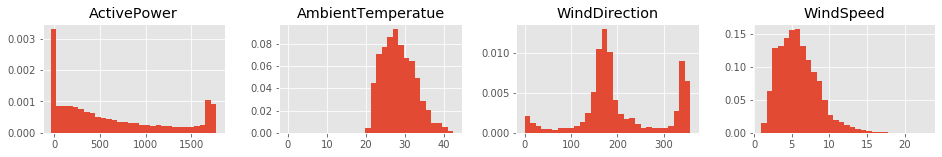

In [14]:
# histograms
data1.hist(figsize=(16, 5), density=True, layout=(2,4), bins=30, sharex=False, sharey=False)
plt.subplots_adjust(hspace=0.5)
plt.show()

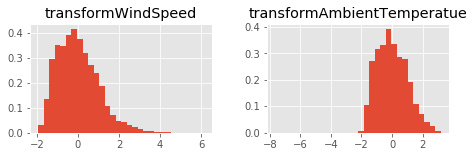

In [15]:
# scaler = QuantileTransformer(output_distribution='normal')
scaler = StandardScaler()


# data1['transformActivePower'] = pd.DataFrame(scaler.fit_transform(np.array(np.log(data1['ActivePower']+100)).reshape(-1, 1)), \
#                                             index=data1.index)

data1['transformWindSpeed'] = pd.DataFrame(scaler.fit_transform(np.array(np.log(data1['WindSpeed']+100)).reshape(-1, 1)),\
                                     index=data1.index)
data1['transformAmbientTemperatue'] = pd.DataFrame(scaler.fit_transform(np.array(np.log(data1['AmbientTemperatue']+100)).reshape(-1, 1)), \
                                            index=data1.index)


data1[['transformWindSpeed','transformAmbientTemperatue']].hist(figsize=(16, 5), \
                                                    density=True, layout=(2,4), bins=30, sharex=False, sharey=False)
plt.subplots_adjust(hspace=0.5)
plt.show()

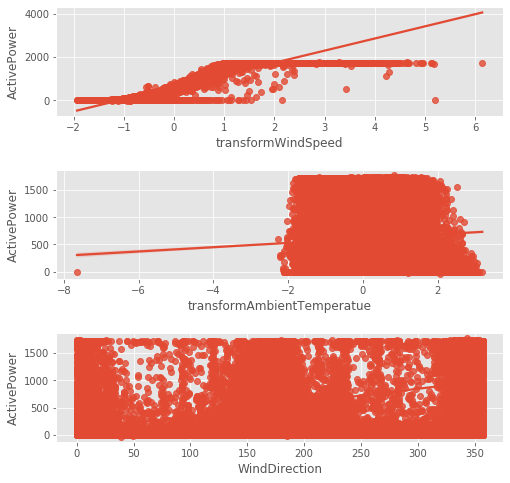

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(8,8))



sns.regplot(x='transformWindSpeed', y='ActivePower', data=data1, logx=False, ax=ax[0])
sns.regplot(x='transformAmbientTemperatue', y='ActivePower', data=data1, logx=False, ax=ax[1])
sns.regplot(x='WindDirection', y='ActivePower', data=data1, logx=False, ax=ax[2])


plt.subplots_adjust(hspace=0.5, wspace= 0.3)
plt.show()

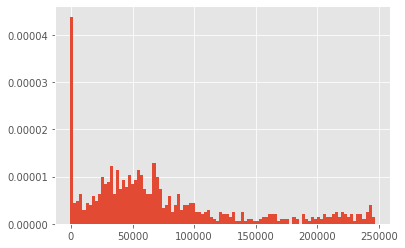

In [17]:
# histograms
data['ActivePower'].resample('D').sum().hist(density=True, bins=100)
plt.subplots_adjust(hspace=1)
plt.show()

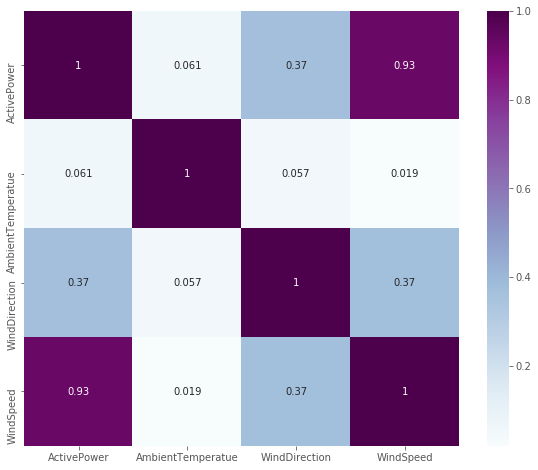

In [20]:
fig = plt.figure(figsize=(10,8))

sns.heatmap(data1[['ActivePower', 'AmbientTemperatue', 'WindDirection', 'WindSpeed']].corr(),\
                            annot=True, cmap='BuPu', square=True, linewidth=0)
b1,t1=plt.ylim()
b1+=0.5
t1-=0.5
plt.ylim(b1, t1)
plt.show()

## Linear model with selected features and droped NaN data

### Without resampling

In [45]:
# names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed', 'Blade1PitchAngle']
names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed']
X = data1[names_features]
Y = data1.iloc[:, 0]
X = X.copy()
Y = Y.copy()
scaler = StandardScaler()
# scaler = MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), index=X.index)

validation_size = 0.2
seed = 5
tscv = TimeSeriesSplit(n_splits=10)

# for train_index, test_index in tscv.split(X):
# ...     X_train, X_test = X[train_index], X[test_index]
# ...     y_train, y_test = y[train_index], y[test_index]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=None, shuffle=False)

In [23]:
# My cross-validation by Time Series
def cv_ts(X, Y, n):  
    
    cv_array = []
    tscv = TimeSeriesSplit(n_splits=n)
    
    for train_index, test_index in tscv.split(X):
        X_train1, X_test1 = X.iloc[train_index], X.iloc[test_index]
        Y_train1, Y_test1 = Y.iloc[train_index], Y.iloc[test_index]

        model = LinearRegression(normalize=True)
        model.fit(X_train1, Y_train1)
        
        cv_array.append(mean_absolute_error(model.predict(X_train1), Y_train1))
    
    return np.array(cv_array).mean()

In [24]:
print(f'MAE: {round(cv_ts(X, Y, 15), 3)}')

MAE: 172.615


In [25]:
model = LinearRegression(normalize=True)

# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'

# kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
# cv = cross_val_score(model, X_train, Y_train, cv=tscv, scoring=scoring)

#cross-validation by time series
cv = cross_val_score(model, X_train, Y_train, cv=tscv.split(X_train), scoring=scoring)
print(f'MAE: {round(abs(cv.mean()), 3)}')

MAE: 173.663


In [26]:
model.fit(X_train, Y_train)

LinearRegression(normalize=True)

In [27]:
model.coef_

array([ 24.96292547,  24.62738703, 535.52412147])

In [28]:
print(f'R2: {round(model.score(X_train, Y_train), 3)}')

R2: 0.874


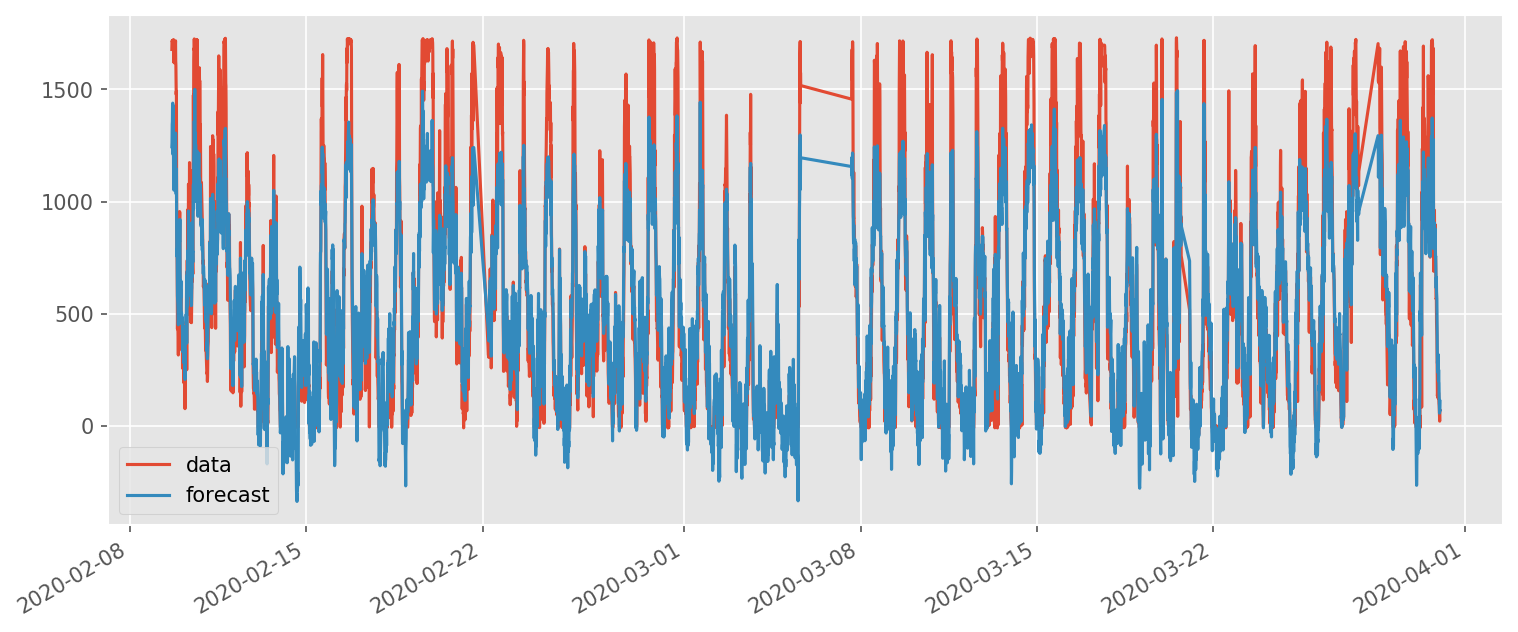

In [29]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

df1 = pd.DataFrame(Y_test.values, index=X_test.index, columns=['data'])
df1['forecast'] = model.predict(X_test)
df1.plot(ax=ax)

plt.legend()
plt.show()

### Transform to Normal distribution

In [72]:
names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed']
X = data1[names_features]
Y = data1.iloc[:, 0]
X = X.copy()
Y = Y.copy()
X.loc[:, ['AmbientTemperatue', 'WindSpeed']] = np.log(X.loc[:, ['AmbientTemperatue', 'WindSpeed']]+200)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index)
# Y = pd.DataFrame(scaler.fit_transform(np.array(Y).reshape(-1, 1)), index=Y.index)



validation_size = 0.2
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed, shuffle=False)

In [73]:
model = LinearRegression(normalize=True)
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
# kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

tscv = TimeSeriesSplit(n_splits=15)
cv = cross_val_score(model, X_train, Y_train, cv=tscv.split(X_train), scoring=scoring)
print(f'MAE: {round(abs(cv.mean()), 3)}')
model.fit(X_train, Y_train)

MAE: 172.152


LinearRegression(normalize=True)

In [32]:
print(f'R2: {round(model.score(X_train, Y_train), 3)}')

R2: 0.876


In [33]:
model.coef_

array([ 26.16213635,  24.64874618, 536.4475605 ])

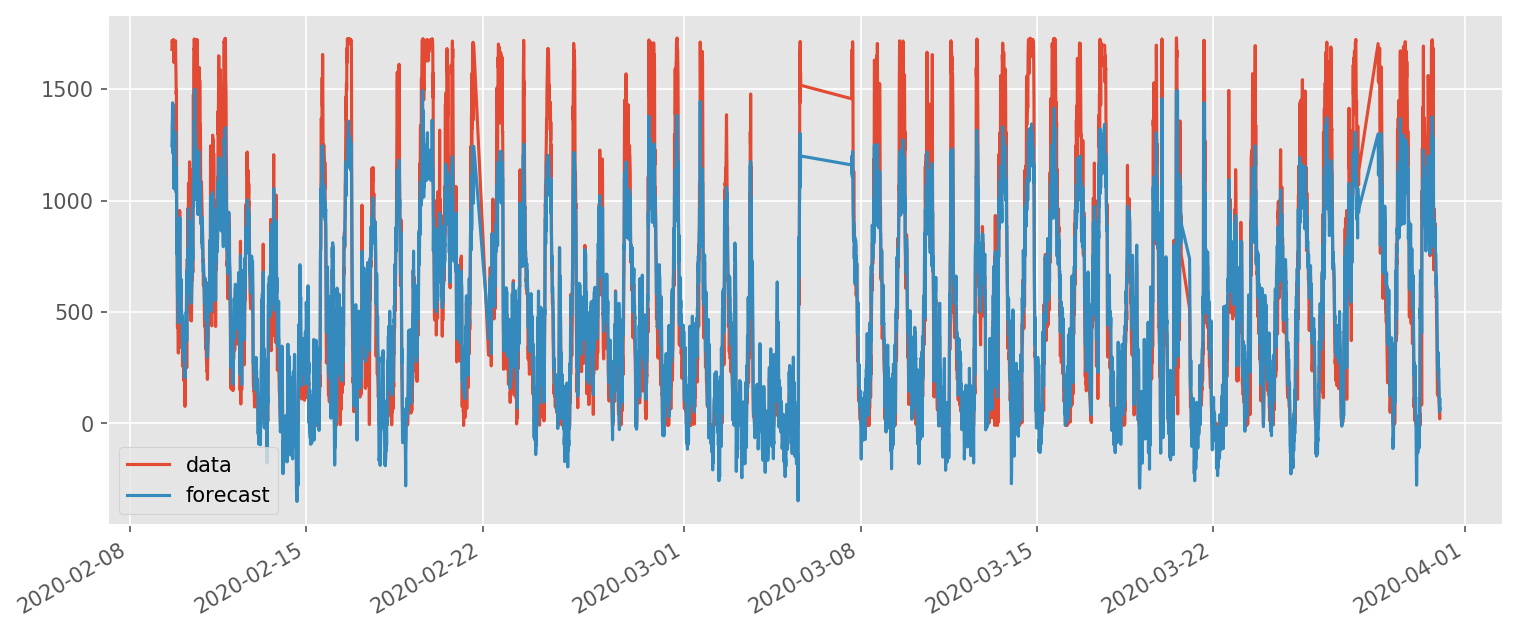

In [392]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
df1 = pd.DataFrame(Y_test.values,\
                           index=X_test.index, columns=['data'])
df1['forecast'] = model.predict(X_test)
df1.plot(ax=ax)
plt.legend()
plt.show()

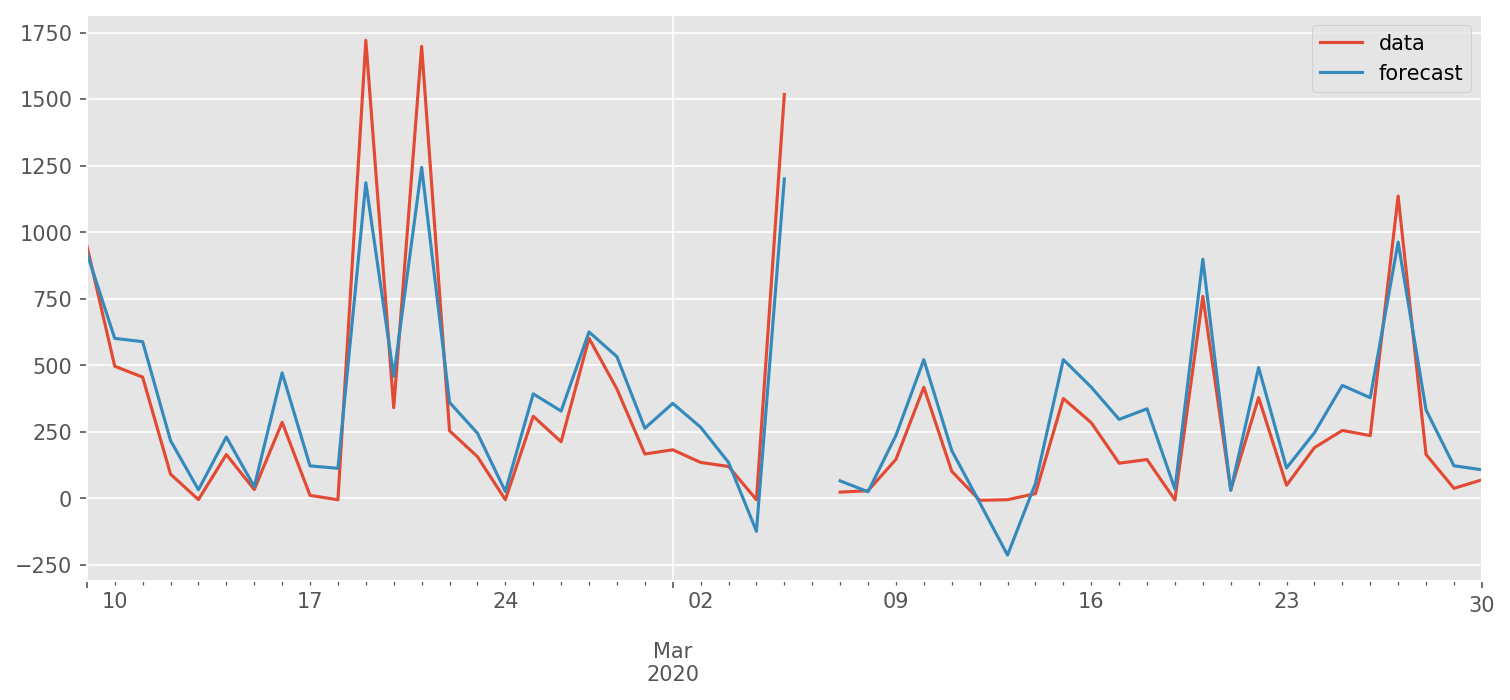

In [393]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

df1.resample('D').last().plot(ax=ax)
plt.legend()
plt.show()

### Generalized linear model

In [49]:
# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), index=X.index)

linear_regression = sm.GLM(data1['ActivePower'], data1[names_features], \
                           family=sm.families.Gaussian())

# linear_regression = sm.GLM(Y_train, X_train, \
#                            family=sm.families.Gaussian())
lin_model_results = linear_regression.fit()

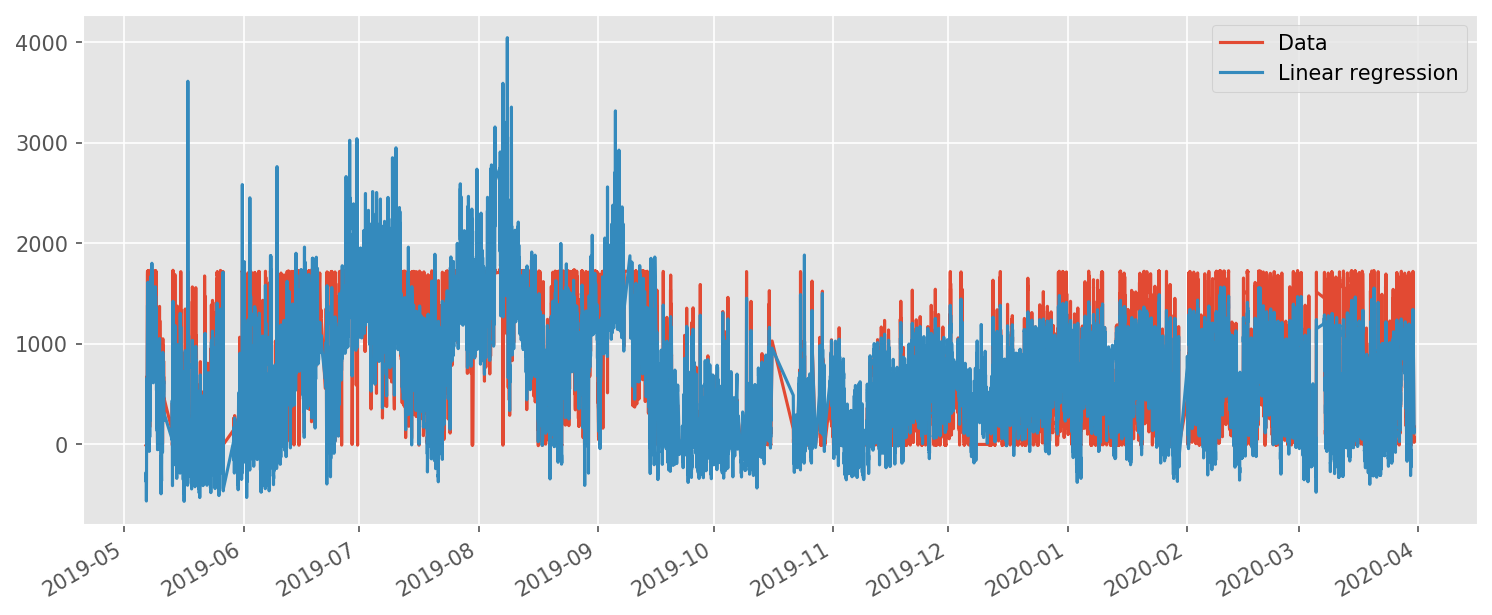

In [50]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
data1['ActivePower'].plot(label='Data')
lin_model_results.fittedvalues.plot(label='Linear regression')
plt.legend()
plt.show()

In [51]:
res1 = float(mean_absolute_error(data1['ActivePower'], lin_model_results.fittedvalues))
print(f'MAE: {round(res1, 3)}')

MAE: 190.413


### Only prophet

In [89]:
data_prophet = data1[['ActivePower']]
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']
    
model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
model.fit(data_prophet)
    
future = model.make_future_dataframe(periods=14, freq='D')
forecast = model.predict(future)

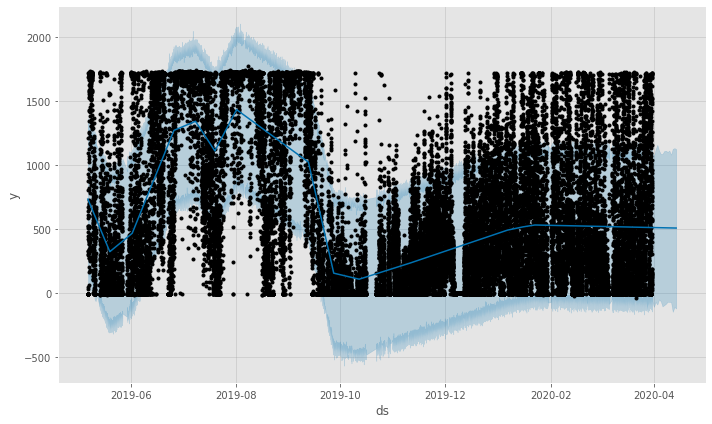

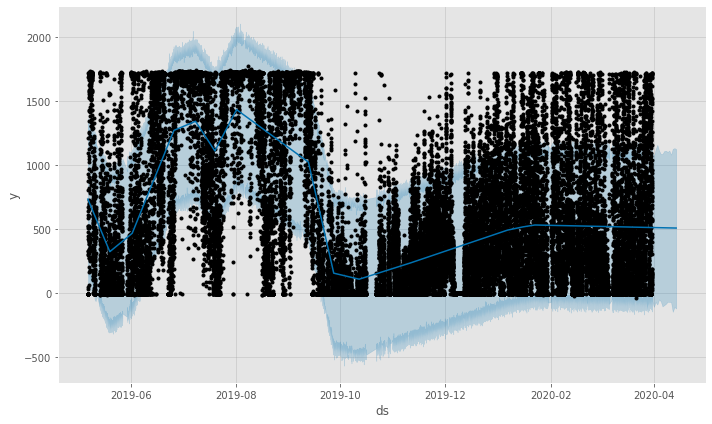

In [90]:
model.plot(forecast)

## Model with selected features and filled data 

In [111]:
names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed']

X = data2[names_features]
Y = data2.iloc[:, 0]
X = X.copy()
Y = Y.copy()
X.loc[:, ['AmbientTemperatue', 'WindSpeed']] = np.log(X.loc[:, ['AmbientTemperatue', 'WindSpeed']]+200)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index)

validation_size = 0.2
seed = 5
tscv = TimeSeriesSplit(n_splits=20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=None, shuffle=False)

model = LinearRegression(normalize=True)

# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
# kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

cv = cross_val_score(model, X_train, Y_train, cv=tscv.split(X_train), scoring=scoring)
print(f'MAE: {round(abs(cv.mean()), 3)}')

MAE: 181.768


In [112]:
model.fit(X_train, Y_train)

LinearRegression(normalize=True)

In [113]:
model.coef_

array([-11.59229383, -16.54073841, 560.71431014])

In [114]:
print(f'R2: {round(model.score(X_train, Y_train), 3)}')

R2: 0.864


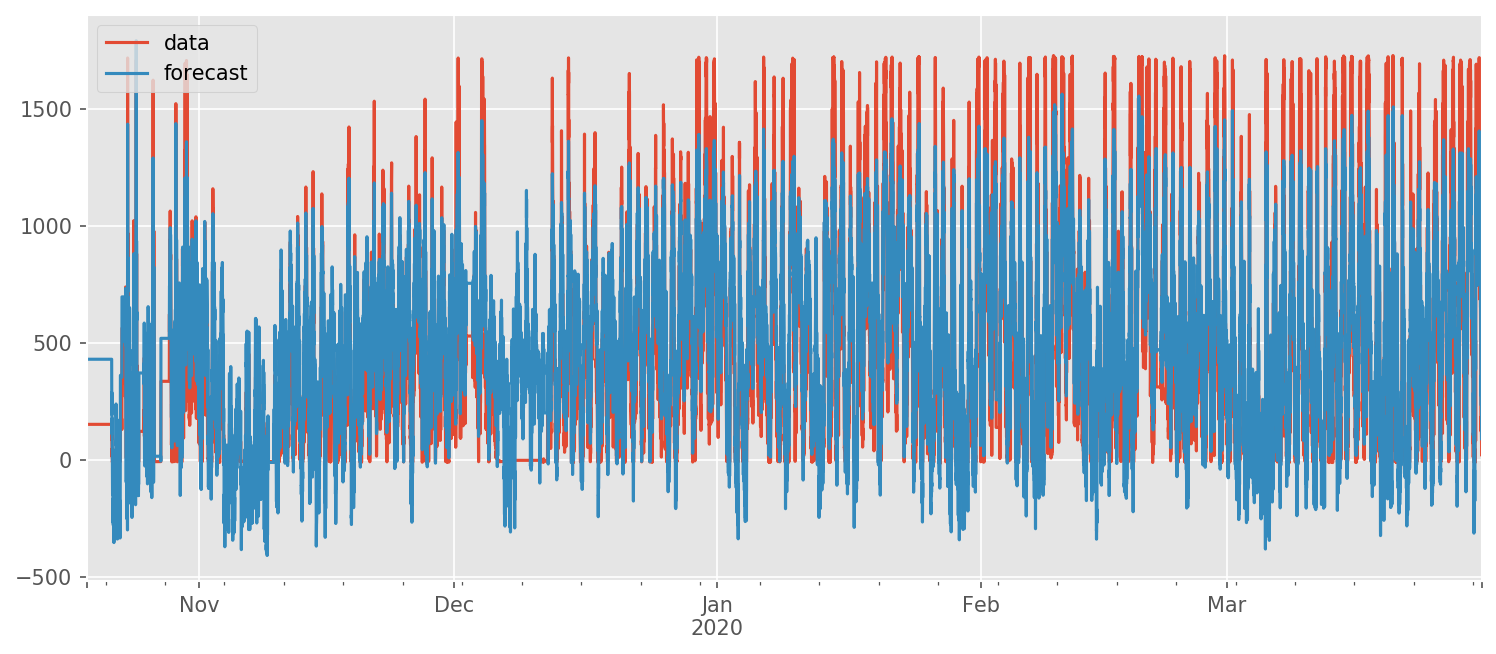

In [115]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

df1 = pd.DataFrame(Y_test.values, index=X_test.index, columns=['data'])
df1['forecast'] = model.predict(X_test)
df1.plot(ax=ax)

plt.show()

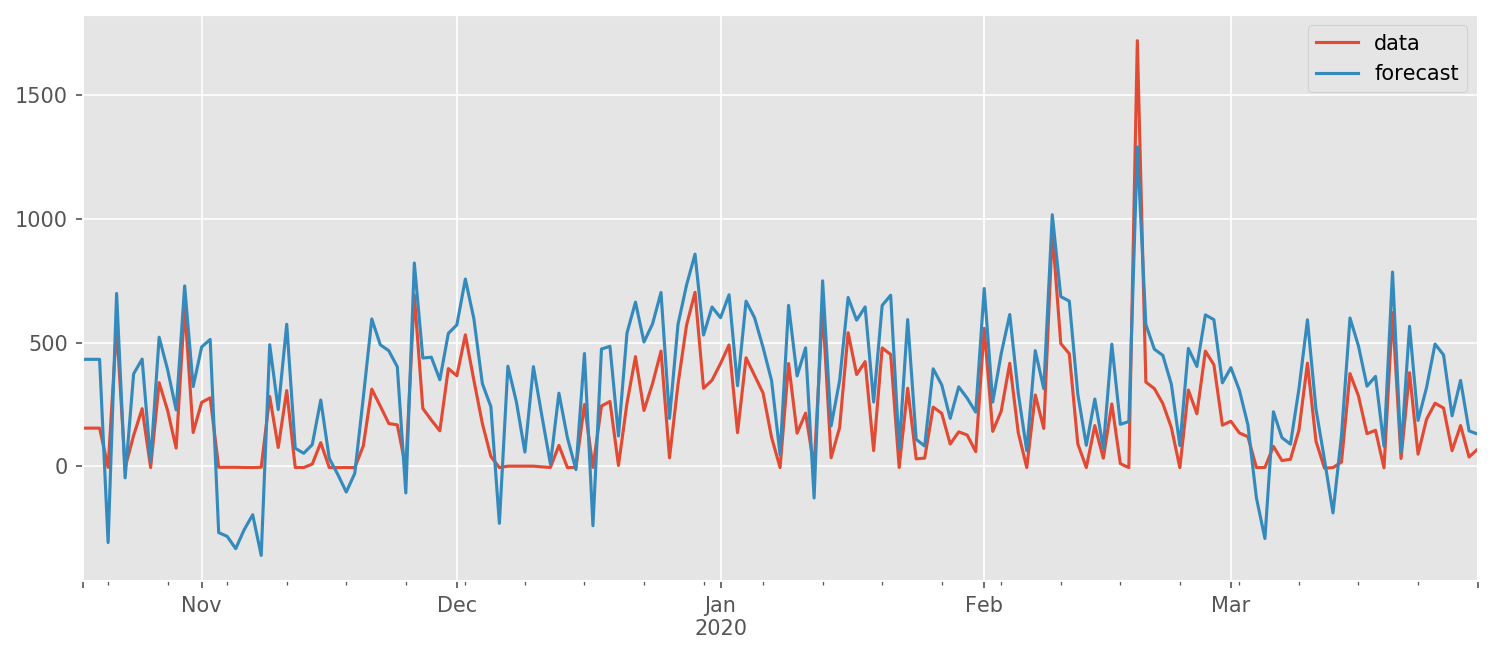

In [116]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

df1.resample('D').last().plot(ax=ax)
plt.legend()
plt.show()

### GLM from statsmodels

In [198]:
linear_regression = sm.GLM(data2['ActivePower'], data2[names_features], \
                           family=sm.families.Gaussian())
lin_model_results = linear_regression.fit()

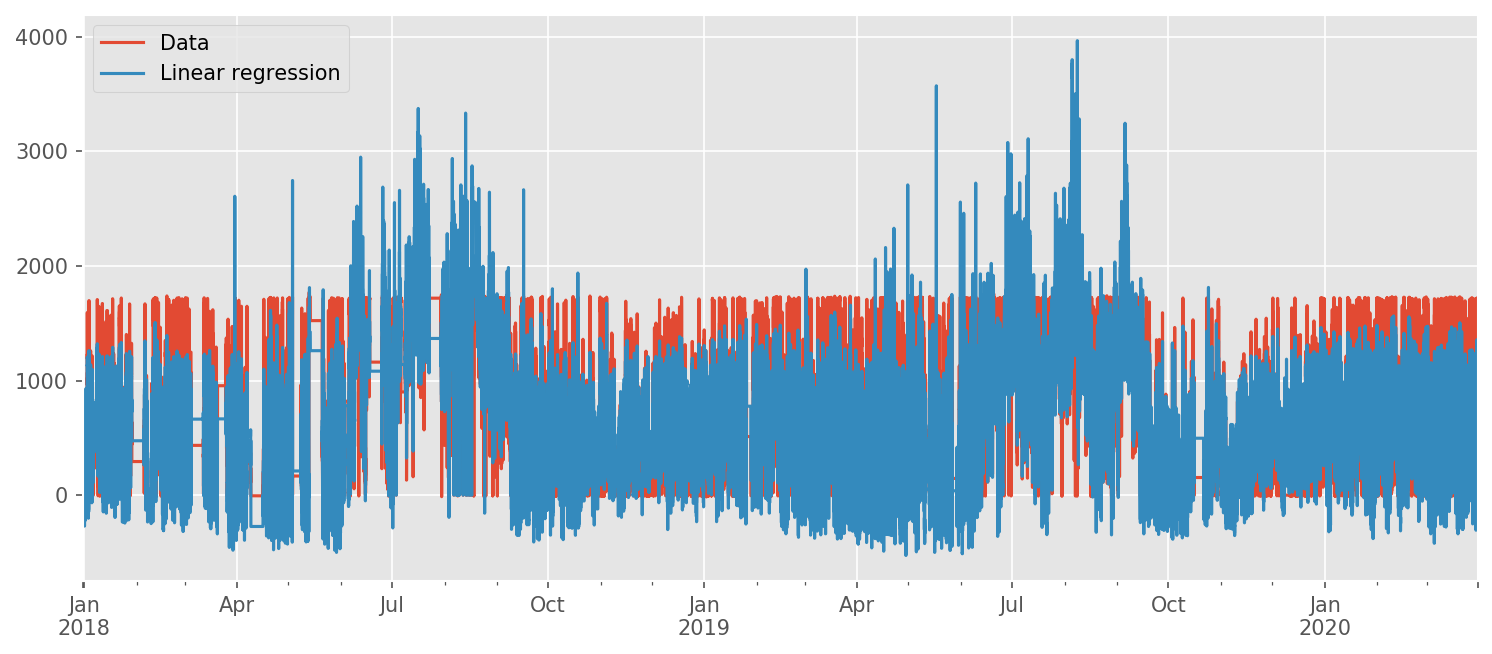

In [199]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
data2['ActivePower'].plot(label='Data')
lin_model_results.fittedvalues.plot(label='Linear regression')
plt.legend(loc=2)
plt.show()

In [200]:
res2 = float(mean_absolute_error(data2['ActivePower'], lin_model_results.fittedvalues))
print(f'MAE: {round(res2, 3)}')

MAE: 188.103


## Prediction

In [19]:
def features_forecast(name, period):    
    data_prophet = data2[[name]]
    data_prophet = data_prophet.reset_index()
    data_prophet.columns = ['ds', 'y']
    
    model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
    model.fit(data_prophet)
    
    future = model.make_future_dataframe(periods=period, freq='10T')
    forecast = model.predict(future)
    return forecast['yhat'].values[-period:]

In [ ]:
forecast_values = []
names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed']
period = 20
for name in names_features:
    forecast_values.append(features_forecast(name, period))

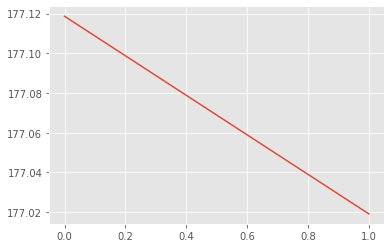

In [15]:
plt.plot(forecast_values[1])

In [438]:
X = data2[names_features]
Y = data2.iloc[:, 0]
X = X.copy()
Y = Y.copy()

X.loc[:, ['AmbientTemperatue', 'WindSpeed']] = np.log(X.loc[:, ['AmbientTemperatue', 'WindSpeed']]+200)

validation_size = 0.2
seed = 5

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed, shuffle=False)

model = LinearRegression(normalize=True)
scoring = 'neg_mean_absolute_error'

tscv = TimeSeriesSplit(n_splits=15)

cv = cross_val_score(model, X_train, Y_train, cv=tscv.split(X_train), scoring=scoring)

print(cv.mean())
model.fit(X_train, Y_train)

np.around(model.coef_)

-185.81537783695208


array([-12., -17., 561.])

In [439]:
start = data3.index[-1] + pd.DateOffset(days=1)
end = start + pd.DateOffset(days=period-1)
forecast_df = pd.DataFrame(model.predict(np.array(forecast_values).T),\
                           index=pd.date_range(start, end), columns=['forecast'])

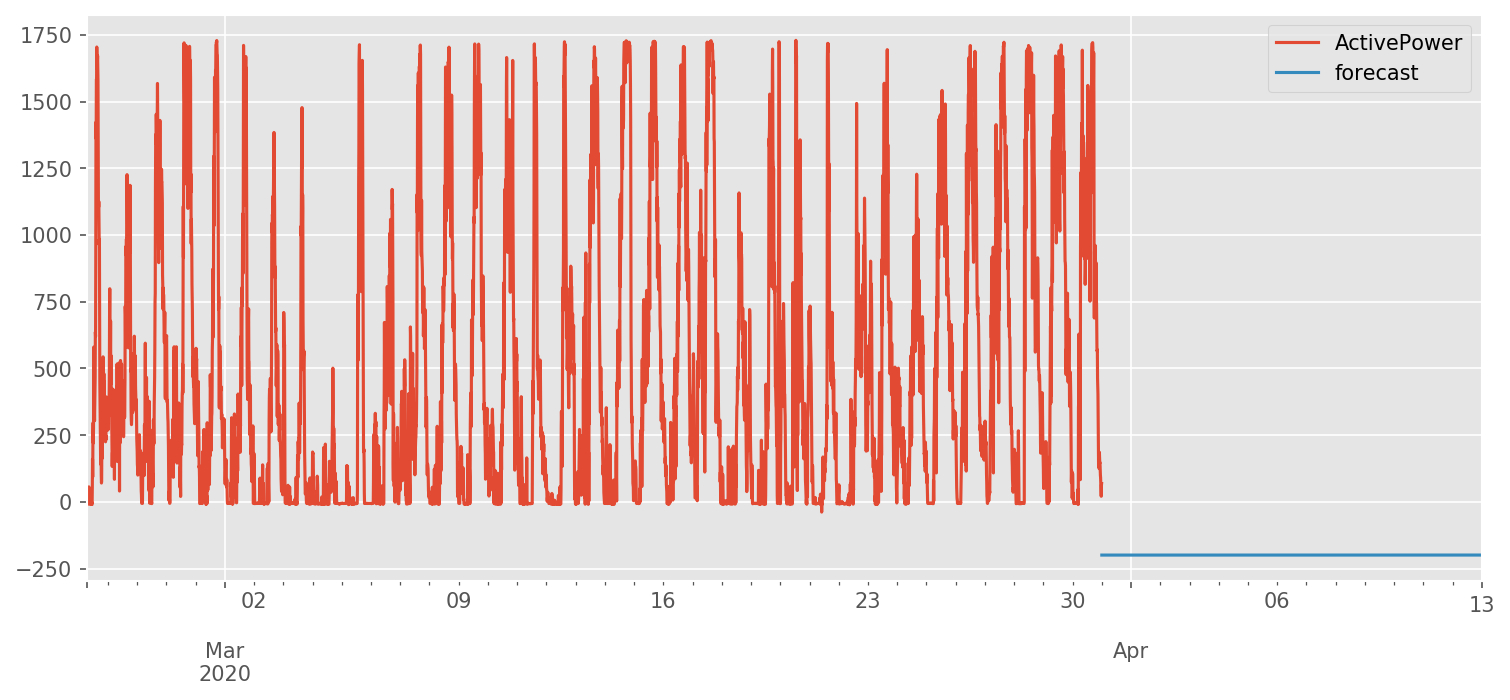

In [443]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

data2['ActivePower'].iloc[-5000:].plot()
forecast_df.plot(ax=ax)
plt.legend()
plt.show()

# ARIMAX

Оптимальный параметр преобразования Бокса-Кокса: 0.232821
Критерий Дики-Фуллера: p=0.000000


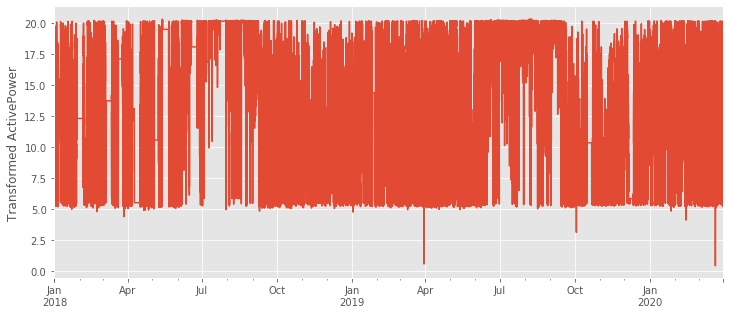

In [203]:
data_sarimax = pd.DataFrame(index = data2.index)
data_sarimax.index = pd.DatetimeIndex(data_sarimax.index, freq='10T')

data_sarimax['ActivePower'] = data2['ActivePower'].values
data_sarimax['WindSpeed'] = data2['WindSpeed'].values
data_sarimax['WindDirection'] = data2['WindDirection'].values
data_sarimax['AmbientTemperature'] = data2['AmbientTemperatue'].values

data_sarimax['ActivePower_box'], lmbda = boxcox(data2['ActivePower']+40)
data_sarimax['const'] = 1
data_sarimax['ActivePower_box'].plot(figsize=(12,5))
plt.ylabel('Transformed ActivePower')

print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)
print('Критерий Дики-Фуллера: p=%f' % adfuller(data_sarimax['ActivePower_box'])[1])

Критерий Дики-Фуллера: p=0.000000


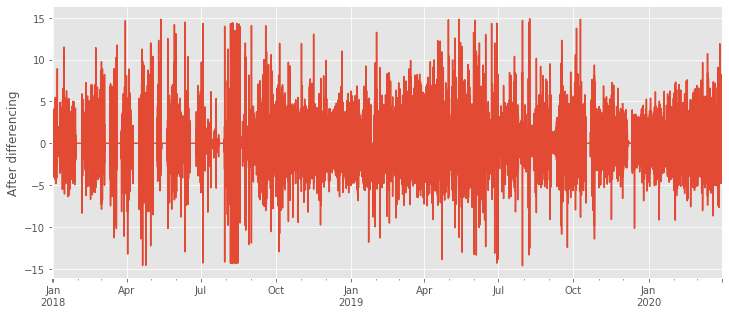

In [204]:
data_sarimax['ActivePower_box_diff'] =  data_sarimax['ActivePower_box'].diff(1)
data_sarimax['ActivePower_box_diff'].plot(figsize=(12,5))
plt.ylabel('After differencing')
print('Критерий Дики-Фуллера: p=%f' % adfuller(data_sarimax['ActivePower_box_diff'].dropna())[1])

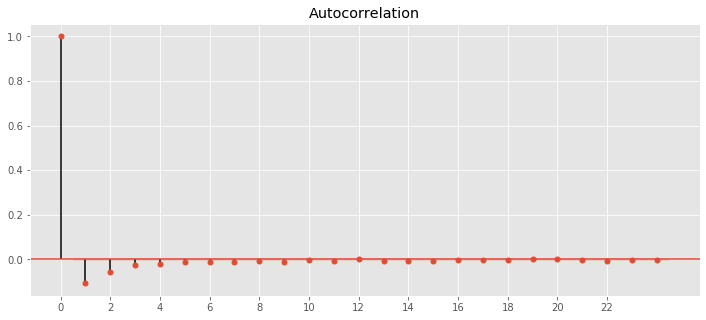

In [213]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(data_sarimax['ActivePower_box_diff'].dropna(), lags=24)
plt.xticks(np.arange(0, 24, 2))
plt.show()

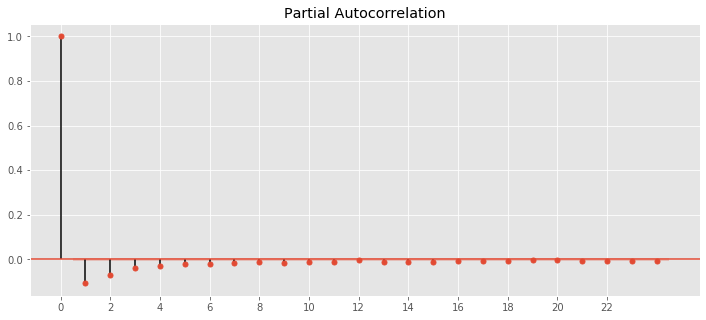

In [206]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(data_sarimax['ActivePower_box_diff'].dropna(), lags=24)
plt.xticks(np.arange(0, 24, 2))
plt.show()

In [104]:
d=1
p = range(1, 5)
q = range(1, 5)

In [98]:
parameters = product(p, q)
parameters_list = list(parameters)

In [99]:
results = []
best_aic = float('inf')

for params in parameters_list:
    try:
        model = SARIMAX(data_sarimax['ActivePower_box'], order=(params[0], d, params[1])).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = params
    results.append([params, model.aic])

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 10T will be used.

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 10T will be used.

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 10T will be used.

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 10T will be used.

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inf

In [100]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

   parameters            aic
15     (4, 4)  386058.494899
3      (1, 4)  386060.576178
12     (4, 1)  386079.776500
2      (1, 3)  386088.434919
7      (2, 4)  386090.688339


In [211]:
model_sarimax = SARIMAX(data_sarimax['ActivePower_box'], order=(1, 1, 1), \
                        exog=data_sarimax[['WindSpeed', 'WindDirection','AmbientTemperature', 'const']]).fit()

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [450]:
# My cross-validation by Time Series
def cv_ts_arimax(X, Y, n):  
    
    cv_array = []
    tscv = TimeSeriesSplit(n_splits=n)
    
    for train_index, test_index in list(tscv.split(X)):
        X_train1, X_test1 = X.iloc[train_index], X.iloc[test_index]
        Y_train1, Y_test1 = Y.iloc[train_index], Y.iloc[test_index]


        model = SARIMAX(Y_train1, order=(1, 1, 1), exog=X_train1).fit()
        df = pd.DataFrame(model.fittedvalues)
        
        if mean_absolute_error(df.values, Y_train1) > 50:
            cv_array.append(mean_absolute_error(df.values, Y_train1))
        else:    
            continue
#         cv_array.append(mean_absolute_error(df.values, Y_train1.drop(df.index[df.apply(np.isnan)][0]).values))
    return np.array(cv_array).mean()

In [451]:
cv_ts_arimax(data_sarimax[['WindSpeed', 'WindDirection','AmbientTemperature', 'const']], data_sarimax['ActivePower_box'],5)

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning:

Mean of empty slice.

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



nan

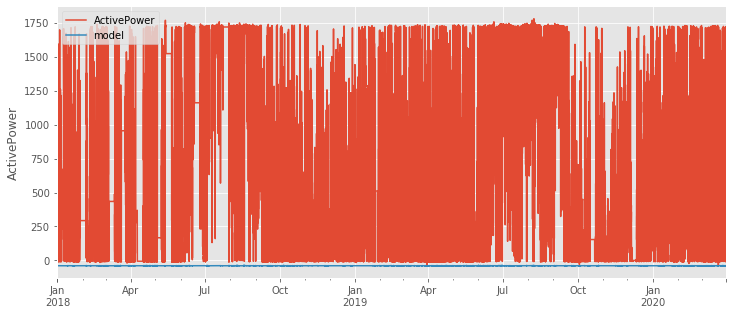

In [210]:
data_sarimax['model'] = inv_boxcox(model_sarimax.fittedvalues, lmbda)-40
data_sarimax['ActivePower'].plot(figsize=(12,5))
data_sarimax.model[13:].plot()
plt.ylabel('ActivePower')
plt.legend(loc=2)
plt.show()

In [168]:
mean_absolute_error(data_sarimax['model'].dropna().values, \
            data_sarimax['ActivePower'].drop(data_sarimax['model'].index[data_sarimax['model'].apply(np.isnan)][0]).values)

66.45105095084635

In [169]:
start = data_sarimax.index[-1] + pd.DateOffset(minutes=10)
end = start + pd.DateOffset(minutes=1440*2)

In [ ]:
data_sarimax.iloc[-500:,0].plot(figsize=(12,5))
inv_boxcox(model_sarimax.predict(start=start, end=end), lmbda).plot()
plt.ylabel('ActivePower')
plt.show()